<IPython.core.display.Javascript object>


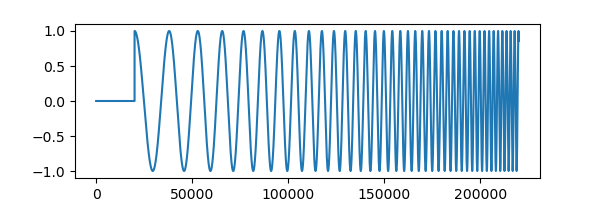

<IPython.core.display.Javascript object>


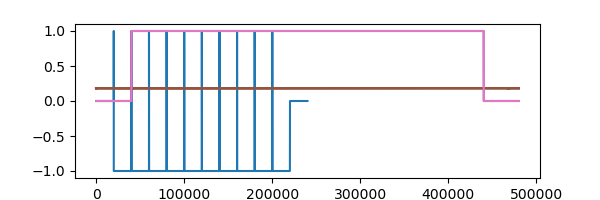

In [6]:
from labdaq import *

%matplotlib notebook
import pylab as plt
plt.figure(figsize=(6,2))
plt.plot(stimgen_waveform([[1,1,0,0,0,0,0,0,0],
                           [10,6,1,1,10,1,0,0,0],
                          [1,1,0,0,1,0,0,0,0,0]]));
plt.figure(figsize=(6,2))
plt.plot(stimgen_waveform([[1,1,0],
                           [10,4,1,1,0.001],
                           [1,1,0]]));



In [4]:
stimgen_waveform?

In [8]:
signal.chirp?

In [1]:
%gui qt5


In [4]:
import os
from PyQt5.QtWidgets import (QApplication,
                             QWidget,
                             QMainWindow,
                             QDockWidget,
                             QFormLayout,
                             QHBoxLayout,
                             QGridLayout,
                             QVBoxLayout,
                             QPushButton,
                             QGridLayout,
                             QTreeWidgetItem,
                             QTreeView,
                             QTextEdit,
                             QLineEdit,
                             QCheckBox,
                             QComboBox,
                             QListWidget,
                             QLabel,
                             QProgressBar,
                             QFileDialog,
                             QMessageBox,
                             QDesktopWidget,
                             QListWidgetItem,
                             QFileSystemModel,
                             QAbstractItemView,
                             QMenu, QAction)

from PyQt5 import QtCore
from PyQt5.QtGui import QStandardItem, QStandardItemModel,QColor
from PyQt5.QtCore import Qt, QTimer,QMimeData
import pyqtgraph as pg

class ProtocolFileViewer(QTreeView):
     def __init__(self,folder,parent=None):
        super(ProtocolFileViewer,self).__init__()
        self.parent = parent
        self.fs_model = QFileSystemModel(self)
        self.fs_model.setReadOnly(True)
        self.setModel(self.fs_model)
        self.folder = folder
        self.setRootIndex(self.fs_model.setRootPath(folder))
        #self.fs_model.removeColumn(1)
        self.setAlternatingRowColors(True)
        self.setSelectionMode(3)
#         self.setDragEnabled(True)
#         self.setAcceptDrops(True)
#         self.setDragDropMode(QAbstractItemView.DragDrop)
#         self.setDropIndicatorShown(True)
#         #[self.hideColumn(i) for i in range(1,4)]
        self.setColumnWidth(0,self.width()*.3)
        def query_root(self):
            folder = QFileDialog().getExistingDirectory(self,"Select directory",os.path.curdir)
            self.setRootIndex(self.fs_model.setRootPath(folder))
            self.expandAll()
            self.folder = folder
            if hasattr(self.parent,'folder'):
                self.parent.folder.setText('{0}'.format(folder))
# A widget to display and generate protocol files
class StimgenWidget(QWidget):
    def __init__(self,protocolsfolder = None):
        super(StimgenWidget,self).__init__()
        #mainw = QWidget()
        #self.setWidget(mainw)
        lay = QGridLayout()
        self.setLayout(lay)
        self.fbrowse = ProtocolFileViewer(os.path.expanduser('~')+'/lib/labdaq')
        self.stimgenfile = QTextEdit()
        self.plotw = pg.PlotWidget()
        self.plots = []
        lay.addWidget(self.fbrowse,0,0,2,1)
        lay.addWidget(self.stimgenfile,2,0,1,2)
        lay.addWidget(self.plotw,0,1,1,2)
        self.srate = 20000
        prot = [[.5,1,0,10,1,0,0,0,0,0],
                [0.1,1,-500,0,0,0,0,0,0,0],
                [1,1,1,0,0,0,0,0,0,0],
                [1,1,-200,0,0,0,0,0,0,0],
                [1.5,1,0,10,0,0,0,0,0,0],
                [20,2,0,20,0,0,0,0,0,0],
                [1,1,0,0,1,0,0,0,0,0]]
        txt = '\n'.join(['\t'.join([str(a) for a in x]) for x in prot]) 
        x = stimgen_waveform([[.5,1,0,10,1,0,0,0,0,0],
                              [0.1,1,-500,0,0,0,0,0,0,0],
                              [1,1,1,0,0,0,0,0,0,0],
                              [1,1,-200,0,0,0,0,0,0,0],
                              [1.5,1,0,10,0,0,0,0,0,0],
                              [20,2,0,20,0,0,0,0,0,0],
                              [1,1,0,0,1,0,0,0,0,0]])
        self.plots.append(self.plotw.plot(np.arange(len(x))/self.srate,x))
        self.stimgenfile.setText(txt)
test = StimgenWidget()
test.show()

In [1]:
# load and run
expfile = 'C:/Users/tony/labdaq/default/protocols/spontaneous/spont.expprot'
from labdaq import *
from labdaq.nidaq import IOTask

pref = get_preferences()
task = IOTask(pref['channels'],pref['channel_modes'])
    

In [2]:
from datetime import datetime
import socket

recorderpars = dict(pref['recorder'],subject = 'test')

expdict = parse_experiment_protocol(expfile)
expdict,stim,digistim = parse_experiment(expdict,task)


recorderpars['prot'] = os.path.basename(os.path.splitext(expfile)[0])
# this will load and run
if 'labcams' in expdict.keys():
    labcamsaddress = expdict['labcams'].split(':')
    labcamsaddress[-1] = int(labcamsaddress[-1])
    labcamsaddress = tuple(labcamsaddress)

    udplabcams = socket.socket(socket.AF_INET,
                           socket.SOCK_DGRAM)
    udplabcams.sendto(b'softtrigger=0', labcamsaddress)
    time.sleep(0.01)
    udplabcams.sendto(b'manualsave=0', labcamsaddress)
    time.sleep(0.01)
    
for itrial in range(expdict['ntrials']):
    tstart = time.time()
    recorderpars['datetime'] = datetime.now().strftime("%Y%m%d_%H%M%S")
    # get the filename
    filename = os.path.basename(pref['recorder']['path'])+'_{itrial}.{format}'
    recorderpars['filename'] = pjoin(recorderpars['path'], filename)
    recorderpars['itrial'] = itrial
    filename = recorderpars['filename'].format(**recorderpars)
    if 'labcams' in expdict.keys():
        udplabcams.sendto('expname={0}'.format(filename).encode('utf-8'), labcamsaddress)    
        time.sleep(0.01)
        udplabcams.sendto(b'manualsave=1', labcamsaddress)
        time.sleep(0.01)
        udplabcams.sendto(b'softtrigger=1', labcamsaddress)
        time.sleep(0.01)
        udplabcams.sendto('log=trial:{0}'.format(itrial).encode('utf-8'), labcamsaddress)
        time.sleep(0.01)
    task.load(stim = stim,digstim = digistim)
    # check if you need to load labcams
    
    task.run(blocking=True)
    taskdone = True
    if taskdone:
        if 'labcams' in expdict.keys():
            udplabcams.sendto(b'softtrigger=0', labcamsaddress)
            time.sleep(0.1)
            udplabcams.sendto(b'manualsave=0', labcamsaddress)
        # save
        h5_save(filename,task,pref,stim=stim,digistim=digistim)
    if 'iti' in expdict.keys():
        tpassed = time.time() - tstart
        ttotal = expdict['duration'] - expdict['iti']
        if ( ttotal >= tpassed): 
            time.sleep(ttotal - tpassed)
if 'labcams' in expdict.keys():
    udplabcams.close()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

C:\Users\tony\miniconda3\lib\site-packages\ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


<IPython.core.display.Javascript object>


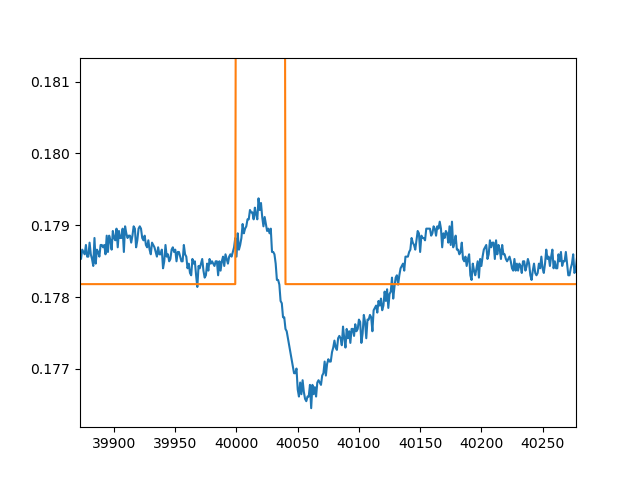

C:\Users\tony\miniconda3\lib\site-packages\ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


In [30]:
import h5py as h5
fname = 'C:/data/test/ephys/20200823_212814_pulsedopto_lfp_test/20200823_212814_pulsedopto_lfp_test_4.h5'
%matplotlib notebook
import pylab as plt


fd = h5.File(fname.format(itrial),'r')
v = fd['ephys_in'].value
plt.plot(v)
if itrial == 1:
    plt.plot(v.mean() + fd['opto_out_ch0'].value/100)
plt.show()

<IPython.core.display.Javascript object>


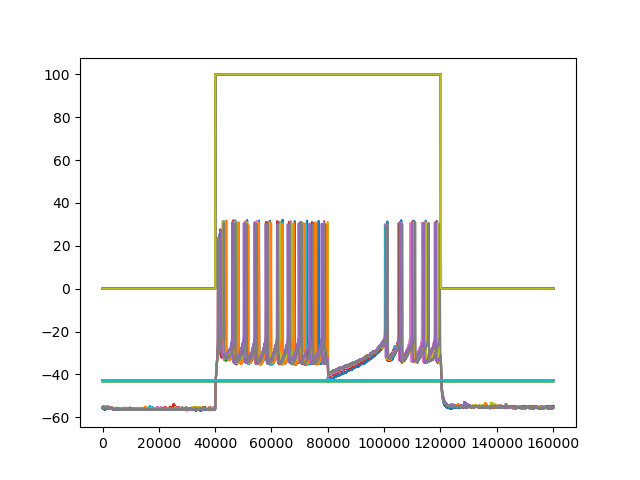

In [36]:
import h5py as h5

fname = 'C:/data/test/ephys/20200823_230023_opto_inhib_test/20200823_230023_opto_inhib_test_{0}.h5'

%matplotlib notebook
import pylab as plt

for i in range(10):
    fd = h5.File(fname.format(i),'r')
    v = fd['ephys_in'][:]
    plt.plot(v)
    if itrial == 1:
        plt.plot(fd['ephys_out'][:])
        plt.plot(v.mean() + fd['opto_out_ch0'][:])
    fd.close()
plt.show()

In [37]:
with h5.File(fname.format(i),'r') as fd:
    print(fd.keys())

<KeysViewHDF5 ['ephys_in', 'ephys_out', 'opto_out_ch0']>
